In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
#| default_exp alg/em_torch

In [78]:
#| hide
from nbdev.showdoc import *

In [79]:
#| export
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.multivariate_normal import MultivariateNormal

In [80]:
#| export
# There are many errors from naive openai generate code like
# not using scale_tril etc
class GMM(nn.Module):
    def __init__(self, n_components, n_features, low=-4.0, high=4.0):
        super(GMM, self).__init__()
        self.n_components = n_components
        self.n_features = n_features
        
        # Initialize parameters as trainable variables
        self.means = nn.Parameter(torch.empty(n_components, n_features).uniform_(low, high))
        self.scale_tril = nn.Parameter(torch.stack([torch.tril(torch.eye(n_features)) for _ in range(self.n_components)]))
        self.log_weights = nn.Parameter(torch.zeros(n_components))
        # print(f"{self.n_components}, {self.n_features} mean: {self.means} variances {self.covariances}")

    @property
    def covariances(self):
        return torch.matmul(self.scale_tril, self.scale_tril.transpose(1, 2))
    
    def _e_step(self, X):
        """Compute responsibilities (E-step)."""
        n_samples = X.shape[0]
        weights = torch.softmax(self.log_weights, dim=0)  # Normalize weights
        responsibilities = torch.zeros(n_samples, self.n_components)
        
        for k in range(self.n_components):
            # Ensure positive-definiteness of covariance matrices
            mvn = MultivariateNormal(self.means[k], scale_tril=self.scale_tril[k])
            responsibilities[:, k] = weights[k] * mvn.log_prob(X).exp()
            # print(f"K {k}: mean {self.means[k]} responsibilities{responsibilities[-10:, k]}")
        
        # Normalize responsibilities across components
        responsibilities /= responsibilities.sum(dim=1, keepdim=True)
        # print(f"responsibilities: {responsibilities[:10, :]}")
        return responsibilities


    def _m_step(self, X, responsibilities):
        """M step, compute the negative log-likelihood using responsibilities."""
        log_likelihood = 0
        for k in range(self.n_components):
            mvn = MultivariateNormal(self.means[k], scale_tril=self.scale_tril[k])
            log_prob = mvn.log_prob(X)  # Log probability for all points
            log_likelihood += responsibilities[:, k] * (log_prob + F.log_softmax(self.log_weights[k], dim=-1))

        # Negative log-likelihood
        return -log_likelihood.mean()


    def forward(self, X):
        responsibilities = self._e_step(X)
        return self._m_step(X, responsibilities)
    
    def predict(self, X):
        return self._e_step(X)


(300, 2)
tensor([[-2.3927, -1.8264],
        [-2.3420, -1.0476],
        [ 1.5950,  3.4472],
        [-1.7672, -1.5706],
        [-0.2579, -4.5390],
        [-1.1969, -2.9935],
        [-1.1661, -2.5902],
        [-2.6071, -0.6012],
        [ 2.8814,  2.5722],
        [ 2.1034,  1.3890]], dtype=torch.float64) [1 1 0 1 1 1 1 1 0 0]
Epoch 1/1000, Loss: 7.0053
Epoch 2/1000, Loss: 5.8234
Epoch 3/1000, Loss: 5.0880
Epoch 4/1000, Loss: 4.5887
Epoch 5/1000, Loss: 4.2412
Epoch 6/1000, Loss: 3.9928
Epoch 7/1000, Loss: 3.8113
Epoch 8/1000, Loss: 3.6764
Epoch 9/1000, Loss: 3.5748
Epoch 10/1000, Loss: 3.4963
Epoch 11/1000, Loss: 3.4323
Epoch 12/1000, Loss: 3.3769
Epoch 13/1000, Loss: 3.3285
Epoch 14/1000, Loss: 3.2863
Epoch 15/1000, Loss: 3.2523
Epoch 16/1000, Loss: 3.2275
Epoch 17/1000, Loss: 3.2109
Epoch 18/1000, Loss: 3.2006
Epoch 19/1000, Loss: 3.1942
Epoch 20/1000, Loss: 3.1890
Epoch 21/1000, Loss: 3.1824
Epoch 22/1000, Loss: 3.1726
Epoch 23/1000, Loss: 3.1592
Epoch 24/1000, Loss: 3.1425
Epoc

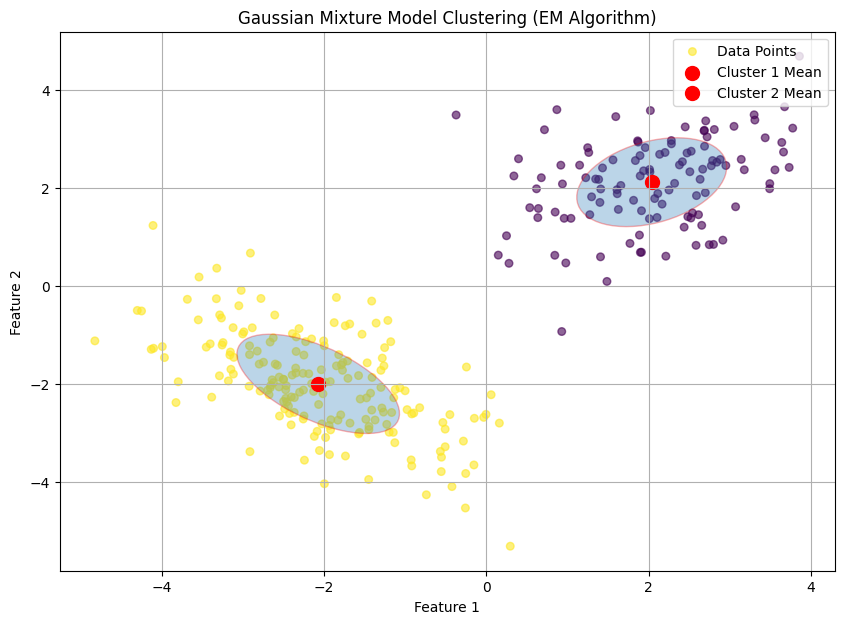

weights [0.79604715 0.20395282]
Means:
[[-2.0715315 -2.0060983]
 [ 2.037614   2.109118 ]]
Covariances:
[[[ 1.0034236  -0.60811627]
  [-0.60811627  1.0257387 ]]

 [[ 0.85294783  0.28419906]
  [ 0.28419906  0.8214668 ]]]
Cluster Assignments:
[0 0 1 0 0 0 0 0 1 1 1 0 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0
 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1
 1 0 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0 1 1 1
 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 1 1
 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0
 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1
 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1
 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0
 0 1 1 0] [1 1 0 1 1 1 1 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1
 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0


In [81]:
import numpy as np
import matplotlib.pyplot as plt

from eval_llm_coding.data import generate_mixed_gaussian_data
from eval_llm_coding.plot import plot_2d_mix_guassian

# Generate synthetic data
np.random.seed(42)
torch.random.manual_seed(23)

means = np.array([[2, 2], [-2, -2]])
covariances = [np.array([[1, 0.5], [0.5, 1]]),
               np.array([[1, -0.5], [-0.5, 1]])
            ]
weights = [0.4, 0.6] 
n_samples = 300

X, y = generate_mixed_gaussian_data(n_samples, means, covariances, weights)
print(X.shape)
X = torch.tensor(X)
print(X[:10], y[:10])

# Train GMM
n_components, n_features = means.shape
gmm = GMM(n_components=n_components, n_features=n_features)

optimizer = optim.Adam(gmm.parameters(), lr=0.1)

n_epochs = 1000
old_loss = 0
tol=1e-6
for epoch in range(n_epochs):
    optimizer.zero_grad()
    loss = gmm(X)  # Loss now incorporates E-step
    loss.backward()
    optimizer.step()
    if abs(old_loss - loss.item()) < tol:
        break
    old_loss = loss.item()
    
    #if (epoch + 1) % 100 == 0:
    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {old_loss:.4f}")

# Predict cluster assignments
gmm.eval()
with torch.no_grad():
    responsibilities = gmm.predict(X)
    labels = responsibilities.argmax(dim=1).detach().numpy()
    responsibilities = responsibilities.detach().numpy()
    means = gmm.means.detach().numpy()
    covariances = gmm.covariances.detach().numpy()
    weights = F.softmax(gmm.log_weights, dim=0).detach().numpy()

# Visualize results
plot_2d_mix_guassian(X.numpy(), means, covariances, y)


# Display results
print(f"weights {weights}")
print("Means:")
print(means)
print("Covariances:")
print(covariances)
print("Cluster Assignments:")
print(labels, y, labels.sum(), y.sum(), (1-labels == y).sum() / len(y))


In [82]:
#| hide
import nbdev; nbdev.nbdev_export()